## Model_with_Color_8x8_Resolution

**Problem Statement:** <br>
Our skin is our body's largest organ and skin cancer is the most common form of cancer. If treated early, skin cancer is highly curable. At this time, the dominant method for skin cancer diagnosis is histopathological, physically removing material and identification in a laboratory. Recognition of the pain involved may dissuade patients from seeking early treatment. Medical professionals have turned to the data science community for a tool for diagnosing skin cancer through image processing. A model that could reliably detect cancer will save lives. The problem is to develop a model that can detect cancer cells by interpreting the image data. Stakeholders in this endeavor are medical professionals and patients with skin lesions

This project seeks to identify images of pigmented skin cells collected by medical staff. The goal of medical researchers is to create a tool that can help to determine which images are of benign vs malignant cells. The datasets are available online at Kaggle and the origin of the set is Medical University of Vienna. The data includes diagnostic information classifying the images into seven categories. Supporting documentation states the images are representatively distributed. The data is available in a wide range of resolutions from 8 x 8 pixels to 450 x 600 pixels. There are seperate notebooks for each level of resolution. Color and greyscale have seperate models as well.

This particular notebook will use color images with a 8 by 8 pixel resolution. It is interesting to note differences in model performance by varying resolution and number of channels(color). All of the models are neural networks and hyperparameters are tweaked to improve performance.

### Table of Contents

[1 Importing Libraries](#1-Importing-Libraries)<br>
[2 Reading in the MetaData and Image Files](#2-Reading-in-the-MetaData-and-Image-Files)<br>
[3 The Diagnosis Column](#3-The-Diagnosis-Column)<br>
[4 Unbalanced Classes](#4-Unbalanced-Classes)<br>
[5 DataFrame](#5-DataFrame)<br>
[6 The Features Column](#6-The-Features-Column)<br>
[7 The Target Column](#7-The-Target-Column)<br>
[8 Train Test Split](#8-Train-Test-Split)<br>
[9 Scaling the image data](#9-Scaling-the-image-data)<br>
[10 Model Construction](#10-Model-Construction)<br>
[11 Feed Forward Neural Network](#11-Feed-Forward-Neural-Network)<br>
[ .    FNN Model](#FNN-Model)<br>
[12 Convolutional Neural Network](#12-Convolutional-Neural-Network)<br>
[ .    CNN Model 1](#CNN-Model-1)<br>
[ .    CNN Model 2](#CNN-Model-2)<br>
[ .    CNN Model 3](#CNN-Model-3)<br>
[ .    CNN Model 4](#CNN-Model-4)<br>

### 1 Importing Libraries

Collecting necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(42)
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils

%matplotlib inline

Using TensorFlow backend.


### 2 Reading in the MetaData and Image Files

The metadata is in seperate file, this line reads in that data and puts it into a pandas dataframe.

In [2]:
skin = pd.read_csv('../../datasets/HAM10000_metadata.csv')

This Low Resolution Image file provides the features, which was downloaded from Kaggle

In [3]:
skin_8by8 = pd.read_csv('../../datasets/hmnist_8_8_RGB.csv')#low res images

Dropping label column(not part of original data) as only pixel data is needed

In [4]:
skin_8by8.drop('label',axis=1, inplace=True)

Joining metadata together with image data to create one DataFrame 192 pixel columns and 7 data columns

In [5]:
skin =pd.concat([skin,skin_8by8],axis = 1)

In [6]:
skin.shape

(10015, 199)

Target Distribution

In [7]:
skin['dx'].value_counts(normalize=True)

nv       0.669496
mel      0.111133
bkl      0.109735
bcc      0.051323
akiec    0.032651
vasc     0.014179
df       0.011483
Name: dx, dtype: float64

### 3 The Diagnosis Column

The two diagnoses I want to focus on are melanoma, 11.1% of the total and basal cell carcinoma, 5.1% of the total. To avoid unbalanced classes, take a random sample of the remaining , noncancer diagnosis purposefully not undersampling the 'nv' which is the most challenging to discern from melanoma as well as the largest portion of diagnoses 66.9%.There are 1627 cancer rows, a random sampling of 1627 noncancer rows will be selected.

In [8]:
malignant=skin[(skin['dx']=='mel')| (skin['dx']=='bcc')]
malignant.shape

(1627, 199)

The other diagnoses are grouped together in the benign subset.

In [9]:
benign= skin[(skin['dx']=='df')|(skin['dx']=='nv')|(skin['dx']=='bkl')|(skin['dx']=='vasc')|(skin['dx']=='akiec')]
benign.shape

(8388, 199)

### 4 Unbalanced Classes

There are many more benign images than malignant and to avoid unbalanced classes, the benign images are shuffled and the top 1627 are chosen.

In [10]:
benign = benign.sample(benign.shape[0],np.random.seed(42), replace = True)
benign.shape

(8388, 199)

For modeling the malignant diagnosis are converted to ones.

In [11]:
malignant['dx'] =1

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [12]:
malignant['dx'].value_counts()

1    1627
Name: dx, dtype: int64

For modeling the noncancerous diagnoses are converted to zeroes

In [13]:
benign['dx']=0

In [14]:
benign['dx'].value_counts()

0    8388
Name: dx, dtype: int64

Malignant and a subset of benign are joined together to become skin_equal

In [15]:
skin_equal = pd.concat((malignant,benign.head(1627)))

In [16]:
skin_equal.shape

(3254, 199)

The image_id is unique to each row, it is set as the index

In [17]:
skin_equal.set_index('image_id', inplace = True)

### 5 DataFrame

This is the beginning of the fully assembled DataFrame, the model will use the pixels columns and the diagnosis(dx) column.



In [18]:
skin_equal.head()

,lesion_id,dx,dx_type,age,sex,localization,pixel0000,pixel0001,pixel0002,pixel0003,...,pixel0182,pixel0183,pixel0184,pixel0185,pixel0186,pixel0187,pixel0188,pixel0189,pixel0190,pixel0191
image_id,,,,,,,,,,,,,,,,,,,,,
ISIC_0025964,HAM_0000871,1,histo,40.0,female,chest,169,143,150,185,...,201,207,183,195,199,171,183,166,138,143
ISIC_0030623,HAM_0000871,1,histo,40.0,female,chest,203,176,192,206,...,206,211,181,205,210,185,207,211,189,206
ISIC_0027190,HAM_0000040,1,histo,80.0,male,upper extremity,148,127,148,161,...,190,168,151,176,161,148,173,149,134,158
ISIC_0031023,HAM_0005678,1,histo,60.0,male,chest,116,92,107,202,...,219,229,212,224,240,227,241,147,131,149
ISIC_0028086,HAM_0005678,1,histo,60.0,male,chest,227,207,229,225,...,248,241,236,241,247,240,247,242,232,243


### 6 The Features Column

Only the pixel data will be used by the model , all the other columns are dropped

In [19]:
X = skin_equal.drop(columns=['lesion_id','dx','dx_type',
                    'age', 'sex','localization'])

In [20]:
X.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel0182,pixel0183,pixel0184,pixel0185,pixel0186,pixel0187,pixel0188,pixel0189,pixel0190,pixel0191
image_id,,,,,,,,,,,,,,,,,,,,,
ISIC_0025964,169,143,150,185,155,169,199,171,185,204,...,201,207,183,195,199,171,183,166,138,143
ISIC_0030623,203,176,192,206,177,197,209,183,199,209,...,206,211,181,205,210,185,207,211,189,206
ISIC_0027190,148,127,148,161,143,165,167,148,169,171,...,190,168,151,176,161,148,173,149,134,158
ISIC_0031023,116,92,107,202,176,199,217,197,220,233,...,219,229,212,224,240,227,241,147,131,149
ISIC_0028086,227,207,229,225,206,225,248,241,255,198,...,248,241,236,241,247,240,247,242,232,243


### 7 The Target Column

In [21]:
y= skin_equal[['dx']]

In [22]:
y.shape

(3254, 1)

### 8 Train Test Split

The data is split into a training set and a testing set so that model performance can be evaluated on unseen data.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = 42, stratify=y)


Making sure to have correct type

In [24]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

Changing to numpy array

In [25]:
X_train=X_train.values
X_test=X_test.values

Looking at X_train shape

In [26]:
X_train.shape

(2440, 192)

In [27]:
y_train.shape

(2440, 1)

Looking at X_train first entry

In [28]:
X_train[0]

array([155., 116., 132., 167., 121., 131., 183., 139., 157., 186., 141.,
       155., 184., 134., 140., 181., 131., 137., 174., 121., 127., 165.,
       123., 133., 160., 116., 133., 172., 127., 140., 186., 141., 156.,
       192., 144., 161., 195., 148., 163., 189., 135., 150., 179., 123.,
       138., 167., 125., 132., 159., 111., 122., 173., 123., 131., 183.,
       135., 146., 178., 115., 117., 178., 112., 112., 187., 122., 133.,
       181., 129., 142., 172., 129., 140., 159., 113., 120., 172., 124.,
       131., 175., 120., 124., 140.,  72.,  71., 153.,  83.,  84., 183.,
       120., 121., 180., 135., 140., 169., 122., 128., 154., 109., 108.,
       168., 123., 126., 162., 100.,  89., 143.,  67.,  72., 155.,  84.,
        94., 182., 129., 132., 177., 128., 133., 166., 121., 130., 149.,
       107., 111., 165., 122., 128., 173., 124., 128., 177., 109., 123.,
       182., 117., 133., 181., 134., 137., 177., 132., 140., 162., 118.,
       126., 139.,  98.,  97., 156., 115., 118., 17

### 9 Scaling the image data

The values range from 0 to 255 depending on intensity. The neural models require scaled data and this can be accomplished by dividing each value by the maximum of 255, In this way, all the values will have a new range between zero and one.

In [29]:
# This scales each value to be between 0 and 1. 
X_train/=255
X_test/=255

In [30]:
# Reshape each image to be 8 x 8 x 3.
X_train = X_train.reshape(X_train.shape[0],8,8,3) 
X_test = X_test.reshape(X_test.shape[0],8,8,3) 


Checking shape of X_train and y_train now

In [31]:
X_train.shape

(2440, 8, 8, 3)

In [32]:
y_train.shape

(2440, 1)

### 10 Model Construction

The features and target are prepared, so the modeling can commence. Neural networks are a branch of models that are known to be able to handle image data well. The most basic Neural Network is the Feed Forward Network and this makes a good starting point as other networks build on this framework. The nodes of the dense layer are interconnected to many other nodes and so the model can learn which connections are important.

### 11 Feed Forward Neural Network

Starting with Feed Forward Neural Network, this model has a flattening layer and three densely connected layers. Evaluation methods are binary crossentropy for loss and accuracy to gauge model performance. Accuracy is measured against a 50% baseline because we have balanced classes. The models are given 20 epochs to see what they can learn.

#### FNN Model

In [33]:
model = Sequential()

model.add(Flatten(input_shape=(8, 8, 3)))

model.add(Dense(128, input_shape=(8, 8, 3), activation='relu'))

model.add(Dense(32, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history = model.fit(X_train,
                    y_train, 
                    batch_size=256,
                    validation_data=(X_test, y_test),
                    epochs=20,
                    verbose=1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 2440 samples, validate on 814 samples
Epoch 1/20
2440/2440 [==============================] - 0s 132us/step - loss: 0.6952 - acc: 0.5676 - val_loss: 0.6765 - val_acc: 0.6376
Epoch 2/20
2440/2440 [==============================] - 0s 14us/step - loss: 0.6693 - acc: 0.6291 - val_loss: 0.6603 - val_acc: 0.5946
Epoch 3/20
2440/2440 [==============================] - 0s 16us/step - loss: 0.6526 - acc: 0.6291 - val_loss: 0.6477 - val_acc: 0.6658
Epoch 4/20
2440/2440 [==============================] - 0s 17us/step - loss: 0.6410 - acc: 0.6328 - val_loss: 0.6375 - val_acc: 0.6646
Epoch 5/20
2440/2440 [==============================] - 0s 19us/step - loss: 0.6304 - acc: 0.6418 - val_loss: 0.6293 - val_acc: 0.6671
Epoch 6/20
2440/2440 [==============================] - 0s 20us/step - loss: 0.6228 - acc: 0.6348 - val_loss: 0.6227 - val_acc: 0.6302
Epoch 7/20
2440/2440 [

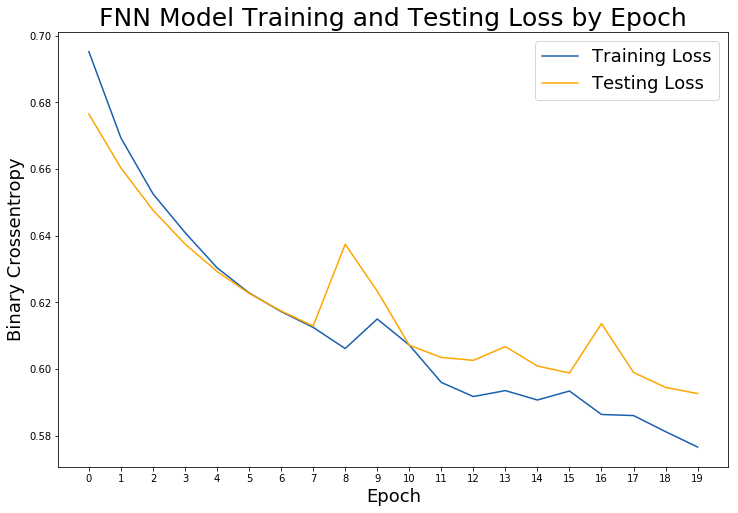

In [34]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('FNN Model Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Binary Crossentropy', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])

plt.legend(fontsize = 18);

This chart shows the model loss performance, it is preferable when the two lines move in tandem with a downward trajectory with little space in between the lines.

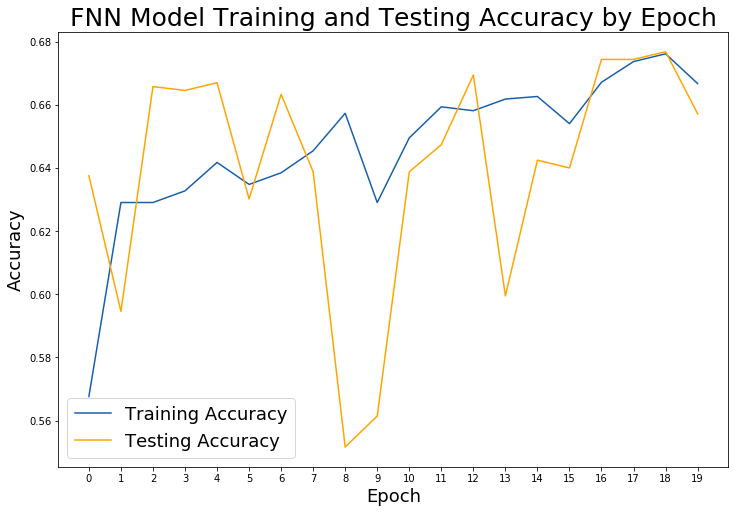

In [35]:
# Check out our train loss and test loss over epochs.
train_accuracy = history.history['acc']
test_accuracy = history.history['val_acc']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(test_accuracy, label='Testing Accuracy', color='orange')

# Set title
plt.title('FNN Model Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19])

plt.legend(fontsize = 18);

This chart shows the model accuracy, it is preferable when the two lines move in tandem with a upward trajectory with little space in between the lines.



In [36]:
# Evaluate model on test data.
score = model.evaluate(X_test, y_test, verbose=0)
labels = model.metrics_names

# Show model performance.
print(f'{labels[0]}: {score[0]}')
print(f'{labels[1]}: {score[1]}')

model.summary()

loss: 0.5926252172971533
acc: 0.6572481576875036
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 192)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               24704     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 28,865
Trainable params: 28,865
Non-trainable params: 0
_________________________________________________________________


This table shows the model's performance and a summary of the model's composition.

### 12 Convolutional Neural Network

Convolutional Neural Networks build on top of the Feed Forward model's framework. This type of Neural Network is known for it's ability to work with image data. This type of network begins with a convoltutional layer. This layer overlays a filter onto the data matrix.This first filtering can be imagined as edge detection.In the next layer another filter attempts to glean the most important information contained in its current position before moving to its next position. In this way, the model tries to distill the most vital signal.



#### CNN Model 1

This model has two convolutional layers, one pooling layer, and two dense layers

In [37]:
# Instantiate a CNN.
cnn_model = Sequential()

# Add a convolutional layer.

cnn_model.add(Conv2D(filters = 6,     # number of filters
                     kernel_size = 3, # height/width of filter
                     activation = 'relu', # activation function 
                     input_shape = (8, 8, 3))) # shape of input (image)

# dimensions of region of pooling
cnn_model.add(MaxPooling2D(pool_size=(2,2))) 

cnn_model.add(Conv2D(16,
                     kernel_size = 3,
                     activation='relu'))

cnn_model.add(Flatten())

# Add a densely-connected layer with 128 neurons.
cnn_model.add(Dense(128, activation='relu'))

# Add a final layer with 1 neuron.
cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Fit model on training data
history = cnn_model.fit(X_train,
              y_train,
              batch_size=256,
              validation_data=(X_test, y_test),          
              epochs=20,
              verbose=1)

Train on 2440 samples, validate on 814 samples
Epoch 1/20
2440/2440 [==============================] - 0s 185us/step - loss: 0.6898 - acc: 0.5574 - val_loss: 0.6863 - val_acc: 0.5393
Epoch 2/20
2440/2440 [==============================] - 0s 34us/step - loss: 0.6828 - acc: 0.5664 - val_loss: 0.6759 - val_acc: 0.6143
Epoch 3/20
2440/2440 [==============================] - 0s 35us/step - loss: 0.6717 - acc: 0.5947 - val_loss: 0.6629 - val_acc: 0.6499
Epoch 4/20
2440/2440 [==============================] - 0s 37us/step - loss: 0.6555 - acc: 0.6422 - val_loss: 0.6442 - val_acc: 0.6351
Epoch 5/20
2440/2440 [==============================] - 0s 42us/step - loss: 0.6387 - acc: 0.6381 - val_loss: 0.6282 - val_acc: 0.6364
Epoch 6/20
2440/2440 [==============================] - 0s 42us/step - loss: 0.6231 - acc: 0.6541 - val_loss: 0.6144 - val_acc: 0.6695
Epoch 7/20
2440/2440 [==============================] - 0s 46us/step - loss: 0.6125 - acc: 0.6590 - val_loss: 0.6105 - val_acc: 0.6830
Epoch 8

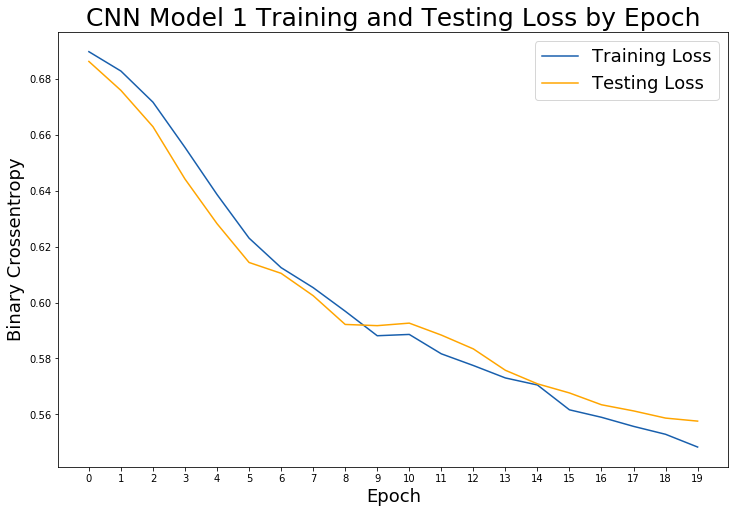

In [38]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('CNN Model 1 Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Binary Crossentropy', fontsize = 18)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])

plt.legend(fontsize = 18);

This chart shows the model loss performance, it is preferable when the two lines move in tandem with a downward trajectory with little space in between the lines.

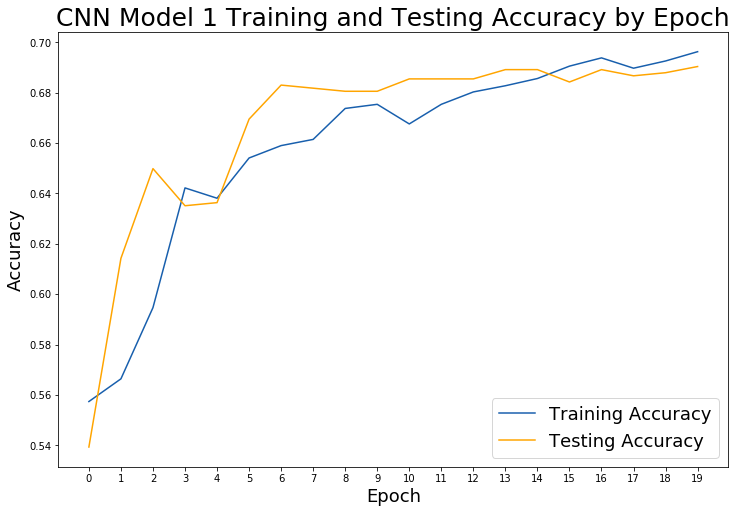

In [39]:
# Check out our train loss and test loss over epochs.
train_accuracy = history.history['acc']
test_accuracy = history.history['val_acc']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(test_accuracy, label='Testing Accuracy', color='orange')

# Set title
plt.title('CNN Model 1 Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19])

plt.legend(fontsize = 18);

This chart shows the model accuracy, it is preferable when the two lines move in tandem with a upward trajectory with little space in between the lines.



In [40]:
cnn_model.summary()

# Evaluate model on test data
cnn_score = cnn_model.evaluate(X_test, y_test, verbose=0)
cnn_labels = cnn_model.metrics_names

# Compare CNN and FFNN models.
print(f'CNN {cnn_labels[0]}  : {cnn_score[0]}')
print(f'CNN {cnn_labels[1]}   : {cnn_score[1]}')
print()
print(f'FFNN {labels[0]} : {score[0]}')
print(f'FFNN {labels[1]}  : {score[1]}')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 6, 6, 6)           168       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 6)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 16)          880       
_________________________________________________________________
flatten_2 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               2176      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 3,353
Trainable params: 3,353
Non-trainable params: 0
_________________________________________________________________
CNN loss

This table shows the model's performance and a summary of the model's composition.

#### CNN Model 2

This second CNN model has one convolutional layer, one pooling layer, three dense layers and two dropouts-which removes some of the densely conected nodes, to reduce congestion and overfitting in the model.

In [41]:
# Instantiate a CNN.
cnn_model_2 = Sequential()

# Add a convolutional layer.
cnn_model_2.add(Conv2D(filters = 16,         # number of filters
                     kernel_size = 3,        # height/width of filter
                     activation='relu',      # activation function 
                     input_shape=(8,8,3))) # shape of input (image)

# Add a pooling layer.
cnn_model_2.add(MaxPooling2D(pool_size=(2,2))) # dimensions of region of pooling



# We have to remember to flatten to go from the "box" to the vertical line of nodes!
cnn_model_2.add(Flatten())

# Add a densely-connected layer with 64 neurons.
cnn_model_2.add(Dense(64, activation='relu'))

# Let's try to avoid overfitting!
cnn_model_2.add(Dropout(0.5))

# Add a densely-connected layer with 16 neurons.
cnn_model_2.add(Dense(16, activation='relu'))

# Let's try to avoid overfitting!
cnn_model_2.add(Dropout(0.5))

# Add a final layer with 1 neuron.
cnn_model_2.add(Dense(1, activation='sigmoid'))

# Compile model
cnn_model_2.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
# Fit model on training data
cnn_model_2.fit(X_train,
                y_train,
                batch_size=128,
                validation_data=(X_test, y_test),
                epochs=20,
                verbose=1)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 2440 samples, validate on 814 samples
Epoch 1/20
2440/2440 [==============================] - 2s 832us/step - loss: 0.6999 - acc: 0.5070 - val_loss: 0.6865 - val_acc: 0.5983
Epoch 2/20
2440/2440 [==============================] - 0s 127us/step - loss: 0.6881 - acc: 0.5553 - val_loss: 0.6743 - val_acc: 0.6609
Epoch 3/20
2440/2440 [==============================] - 1s 223us/step - loss: 0.6791 - acc: 0.5623 - val_loss: 0.6682 - val_acc: 0.6622
Epoch 4/20
2440/2440 [==============================] - 0s 138us/step - loss: 0.6675 - acc: 0.5992 - val_loss: 0.6548 - val_acc: 0.6695
Epoch 5/20
2440/2440 [==============================] - 0s 184us/step - loss: 0.6586 - acc: 0.6152 - val_loss: 0.6417 - val_acc: 0.6880
Epoch 6/20
2440/2440 [==============================] - 0s 104us/step - loss: 0.6586 - acc: 0.5943 - val_loss: 0.6427 - val_acc: 0.5958
Epoch 7/20
2440/2440 [

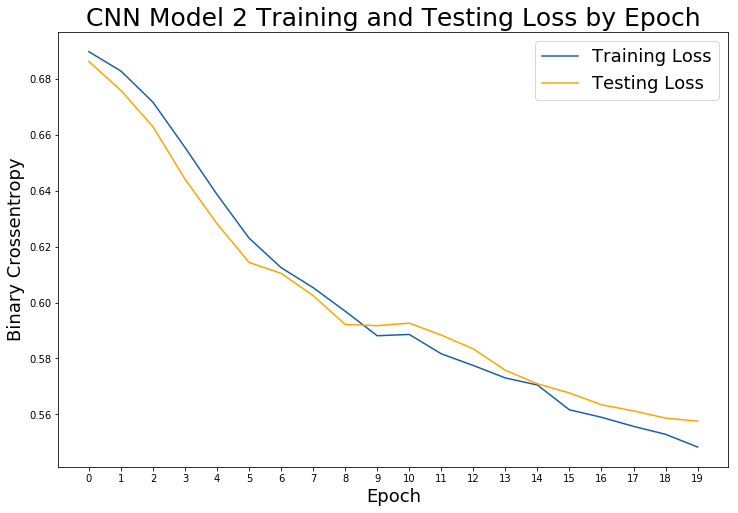

In [42]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('CNN Model 2 Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Binary Crossentropy', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])

plt.legend(fontsize = 18);

This chart shows the model loss performance, it is preferable when the two lines move in tandem with a downward trajectory with little space in between the lines.

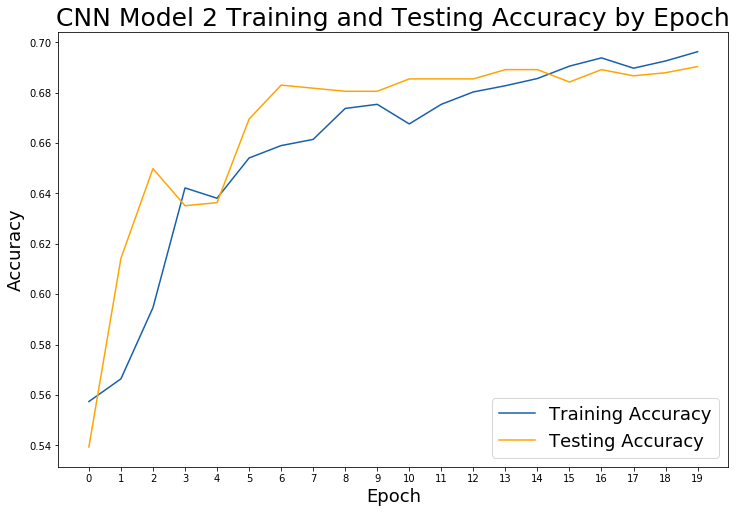

In [43]:
# Check out our train loss and test loss over epochs.
train_accuracy = history.history['acc']
test_accuracy = history.history['val_acc']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(test_accuracy, label='Testing Accuracy', color='orange')

# Set title
plt.title('CNN Model 2 Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19])

plt.legend(fontsize = 18);

This chart shows the model accuracy, it is preferable when the two lines move in tandem with a upward trajectory with little space in between the lines.



In [44]:
# Evaluate model on test data
cnn_2_score = cnn_model_2.evaluate(X_test, y_test, verbose=0)
cnn_2_labels = cnn_model_2.metrics_names

# Compare models.
print(f'CNN 2 {cnn_2_labels[0]}  : {cnn_2_score[0]}')
print(f'CNN 2 {cnn_2_labels[1]}   : {cnn_2_score[1]}')
print()
print(f'CNN 1 {cnn_labels[0]}  : {cnn_score[0]}')
print(f'CNN 1 {cnn_labels[1]}   : {cnn_score[1]}')
print()
print(f'FFNN {labels[0]} : {score[0]}')
print(f'FFNN {labels[1]}  : {score[1]}')

cnn_model_2.summary()

CNN 2 loss  : 0.5620026081727236
CNN 2 acc   : 0.6941031941031941

CNN 1 loss  : 0.5575948925803276
CNN 1 acc   : 0.6904176904176904

FFNN loss : 0.5926252172971533
FFNN acc  : 0.6572481576875036
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 6, 6, 16)          448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 16)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 144)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                9280      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Den

This table shows the model's performance and a summary of the model's composition.

#### CNN Model 3 

In [45]:
# Instantiate a CNN.
cnn_model_3 = Sequential()

# Add a convolutional layer.
cnn_model_3.add(Conv2D(filters = 16,         # number of filters
                     kernel_size = 3,        # height/width of filter
                     activation='relu',      # activation function 
                     input_shape=(8,8,3))) # shape of input (image)

# Add a pooling layer.
cnn_model_3.add(MaxPooling2D(pool_size=(2,2))) # dimensions of region of pooling


# We have to remember to flatten to go from the "box" to the vertical line of nodes!
cnn_model_3.add(Flatten())

# Add a densely-connected layer with 64 neurons.
cnn_model_3.add(Dense(64, activation='relu'))

# Let's try to avoid overfitting!
cnn_model_3.add(Dropout(0.5))

# Add a densely-connected layer with 32 neurons.
cnn_model_3.add(Dense(32, activation='relu'))

# Let's try to avoid overfitting!
cnn_model_3.add(Dropout(0.5))

# Add a final layer with 1 neuron.
cnn_model_3.add(Dense(1, activation='sigmoid'))

# Compile model
cnn_model_3.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['acc']
)

# Fit model on training data
history = cnn_model_3.fit(X_train,
                          y_train,
                          batch_size=128,
                          validation_data=(X_test, y_test),
                          epochs=20,
                          verbose=1)

Train on 2440 samples, validate on 814 samples
Epoch 1/20
2440/2440 [==============================] - 1s 373us/step - loss: 0.6983 - acc: 0.5020 - val_loss: 0.6903 - val_acc: 0.6155
Epoch 2/20
2440/2440 [==============================] - 0s 67us/step - loss: 0.6891 - acc: 0.5316 - val_loss: 0.6856 - val_acc: 0.6548
Epoch 3/20
2440/2440 [==============================] - 0s 65us/step - loss: 0.6832 - acc: 0.5701 - val_loss: 0.6745 - val_acc: 0.6769
Epoch 4/20
2440/2440 [==============================] - 0s 60us/step - loss: 0.6761 - acc: 0.6020 - val_loss: 0.6604 - val_acc: 0.6462
Epoch 5/20
2440/2440 [==============================] - 0s 55us/step - loss: 0.6630 - acc: 0.6230 - val_loss: 0.6421 - val_acc: 0.6118
Epoch 6/20
2440/2440 [==============================] - 0s 55us/step - loss: 0.6454 - acc: 0.6303 - val_loss: 0.6191 - val_acc: 0.6781
Epoch 7/20
2440/2440 [==============================] - 0s 61us/step - loss: 0.6230 - acc: 0.6520 - val_loss: 0.6047 - val_acc: 0.6572
Epoch 8

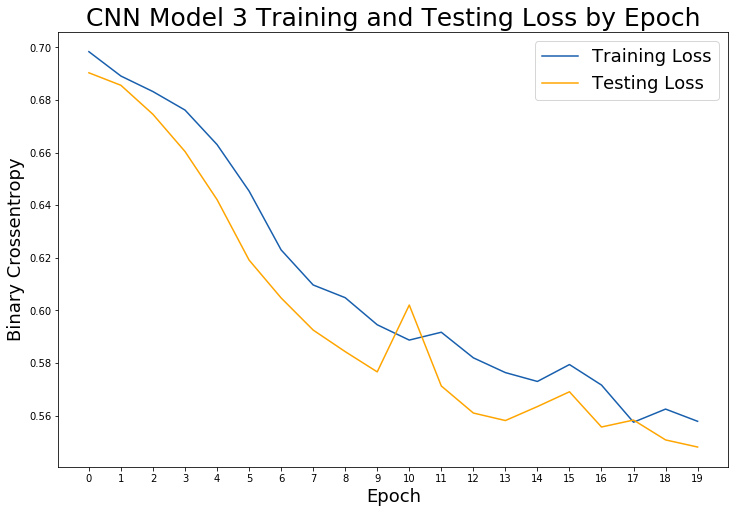

In [46]:
# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('CNN Model 3 Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Binary Crossentropy', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19])

plt.legend(fontsize = 18);

This chart shows the model loss performance, it is preferable when the two lines move in tandem with a downward trajectory with little space in between the lines.

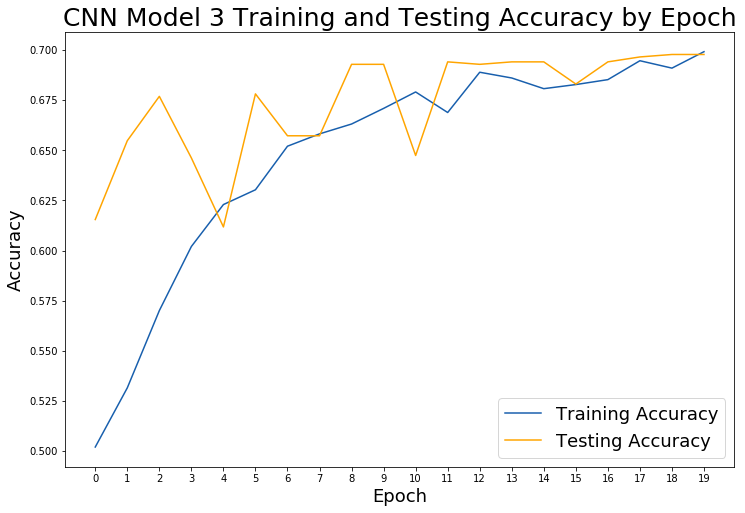

In [47]:
# Check out our train accuracy and test accuracy over epochs.
train_accuracy = history.history['acc']
test_accuracy = history.history['val_acc']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(test_accuracy, label='Testing Accuracy', color='orange')

# Set title
plt.title('CNN Model 3 Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19])

plt.legend(fontsize = 18);

This chart shows the model accuracy, it is preferable when the two lines move in tandem with a upward trajectory with little space in between the lines.



In [48]:
# Evaluate model on test data.
cnn_3_score = cnn_model_3.evaluate(X_test,
                                   y_test,
                                   verbose=1)

cnn_3_labels = cnn_model_3.metrics_names

# Compare models.
print(f'CNN 3 {cnn_3_labels[0]}  : {cnn_3_score[0]}')
print(f'CNN 3 {cnn_3_labels[1]}   : {cnn_3_score[1]}')
print()
print(f'CNN 2 {cnn_2_labels[0]}  : {cnn_2_score[0]}')
print(f'CNN 2 {cnn_2_labels[1]}   : {cnn_2_score[1]}')
print()
print(f'CNN 1 {cnn_labels[0]}  : {cnn_score[0]}')
print(f'CNN 1 {cnn_labels[1]}   : {cnn_score[1]}')
print()
print(f'FFNN {labels[0]} : {score[0]}')
print(f'FFNN {labels[1]}  : {score[1]}')
cnn_model_3.summary()

814/814 [==============================] - 0s 63us/step
CNN 3 loss  : 0.5480197164291831
CNN 3 acc   : 0.6977886977886978

CNN 2 loss  : 0.5620026081727236
CNN 2 acc   : 0.6941031941031941

CNN 1 loss  : 0.5575948925803276
CNN 1 acc   : 0.6904176904176904

FFNN loss : 0.5926252172971533
FFNN acc  : 0.6572481576875036
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 6, 6, 16)          448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 16)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 144)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                9280      
_________________________________________________________________
dropout_3 (Dropout)  

This table shows the model's performance and a summary of the model's composition.

#### CNN Model 4

This fourth CNN model has two convolutional layer, one pooling layer, three dense layers and two dropouts-which removes some of the densely connected nodes, to reduce congestion and overfitting in the model.

In [49]:
# Instantiate a CNN.
cnn_model_4 = Sequential()

# Add a convolutional layer.
cnn_model_4.add(Conv2D(filters = 16,         # number of filters
                     kernel_size = 3,        # height/width of filter
                     activation='relu',      # activation function 
                     input_shape=(8,8,3))) # shape of input (image)
cnn_model_4.add(Conv2D(filters = 32,         # number of filters
                     kernel_size = 3,        # height/width of filter
                     activation='relu'))      # activation function 
                     
# Add a pooling layer.
cnn_model_4.add(MaxPooling2D(pool_size=(2,2))) # dimensions of region of pooling



# We have to remember to flatten to go from the "box" to the vertical line of nodes!
cnn_model_4.add(Flatten())

# Add a densely-connected layer with 64 neurons.
cnn_model_4.add(Dense(64, activation='relu'))

# Let's try to avoid overfitting!
cnn_model_4.add(Dropout(0.5))

# Add a densely-connected layer with 32 neurons.
cnn_model_4.add(Dense(48, activation='relu'))

# Let's try to avoid overfitting!
cnn_model_4.add(Dropout(0.5))

# Add a final layer with 1 neuron.
cnn_model_4.add(Dense(1, activation='sigmoid'))

# Compile model
cnn_model_4.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['acc']
)

# Fit model on training data
history = cnn_model_4.fit(X_train,
                          y_train,
                          batch_size=128,
                          validation_data=(X_test, y_test),
                          epochs=20,
                          verbose=1)

Train on 2440 samples, validate on 814 samples
Epoch 1/20
2440/2440 [==============================] - 1s 467us/step - loss: 0.6941 - acc: 0.5000 - val_loss: 0.6888 - val_acc: 0.6499
Epoch 2/20
2440/2440 [==============================] - 0s 83us/step - loss: 0.6871 - acc: 0.5525 - val_loss: 0.6814 - val_acc: 0.6609
Epoch 3/20
2440/2440 [==============================] - 0s 87us/step - loss: 0.6766 - acc: 0.5779 - val_loss: 0.6648 - val_acc: 0.6425
Epoch 4/20
2440/2440 [==============================] - 0s 86us/step - loss: 0.6607 - acc: 0.6020 - val_loss: 0.6295 - val_acc: 0.6327
Epoch 5/20
2440/2440 [==============================] - 0s 86us/step - loss: 0.6341 - acc: 0.6439 - val_loss: 0.6060 - val_acc: 0.6720
Epoch 6/20
2440/2440 [==============================] - 0s 83us/step - loss: 0.6270 - acc: 0.6381 - val_loss: 0.6015 - val_acc: 0.6830
Epoch 7/20
2440/2440 [==============================] - 0s 88us/step - loss: 0.6134 - acc: 0.6480 - val_loss: 0.6020 - val_acc: 0.6769
Epoch 8

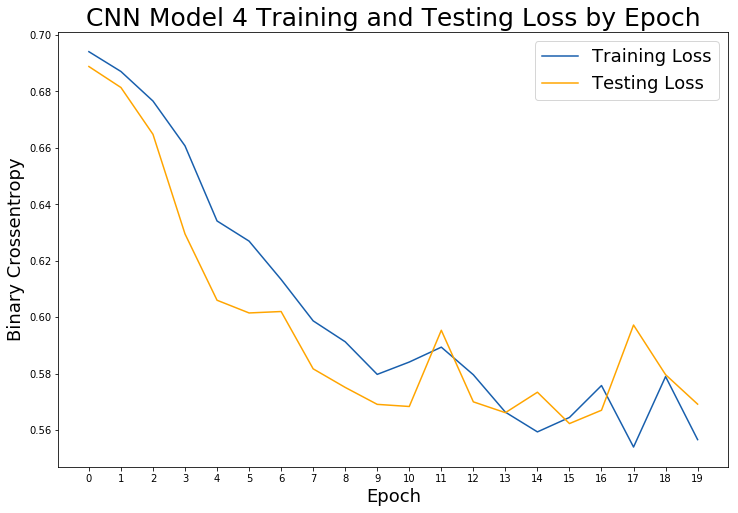

In [50]:
# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('CNN Model 4 Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Binary Crossentropy', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19])

plt.legend(fontsize = 18);

This chart shows the model loss performance, it is preferable when the two lines move in tandem with a downward trajectory with little space in between the lines.

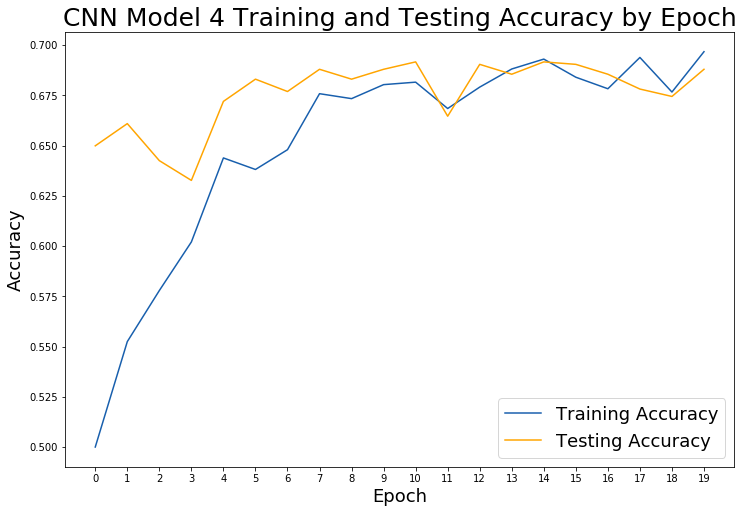

In [51]:
# Check out our train accuracy and test accuracy over epochs.
train_accuracy = history.history['acc']
test_accuracy = history.history['val_acc']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(test_accuracy, label='Testing Accuracy', color='orange')

# Set title
plt.title('CNN Model 4 Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19])

plt.legend(fontsize = 18);

This chart shows the model accuracy, it is preferable when the two lines move in tandem with a upward trajectory with little space in between the lines.



In [52]:
# Evaluate model on test data.
cnn_4_score = cnn_model_4.evaluate(X_test,
                                   y_test,
                                   verbose=1)

cnn_4_labels = cnn_model_4.metrics_names

# Compare models.
print(f'CNN 4 {cnn_4_labels[0]}  : {cnn_4_score[0]}')
print(f'CNN 4 {cnn_4_labels[1]}   : {cnn_4_score[1]}')
print()
print(f'CNN 3 {cnn_3_labels[0]}  : {cnn_3_score[0]}')
print(f'CNN 3 {cnn_3_labels[1]}   : {cnn_3_score[1]}')
print()
print(f'CNN 2 {cnn_2_labels[0]}  : {cnn_2_score[0]}')
print(f'CNN 2 {cnn_2_labels[1]}   : {cnn_2_score[1]}')
print()
print(f'CNN 1 {cnn_labels[0]}  : {cnn_score[0]}')
print(f'CNN 1 {cnn_labels[1]}   : {cnn_score[1]}')
print()
print(f'FFNN {labels[0]} : {score[0]}')
print(f'FFNN {labels[1]}  : {score[1]}')
cnn_model_4.summary()

814/814 [==============================] - 0s 51us/step
CNN 4 loss  : 0.5691694298013129
CNN 4 acc   : 0.687960687960688

CNN 3 loss  : 0.5480197164291831
CNN 3 acc   : 0.6977886977886978

CNN 2 loss  : 0.5620026081727236
CNN 2 acc   : 0.6941031941031941

CNN 1 loss  : 0.5575948925803276
CNN 1 acc   : 0.6904176904176904

FFNN loss : 0.5926252172971533
FFNN acc  : 0.6572481576875036
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 6, 6, 16)          448       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 32)          4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 128)               0         
_____________________

This table shows the model's performance and a summary of the model's composition.